In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.decomposition import PCA


In [71]:
#load feature_data
df = pd.read_csv("feature_data.csv")
#load_label_data
df1 = pd.read_csv("label_data.csv")
#change_column_names
df = df.rename(columns = {'Unnamed: 0':'id'})
df1 = df1.rename(columns = {'Unnamed: 0':'id'})
#merge_data
new_df=pd.merge(df,df1,on=['id'])
new_df.head()

,id,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,...,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13,cancelation
0,51014,309.0,2016,May,week_20,13,2,0.0,0,PRT,...,0.0,215.0,0.0,0,0.0,0.250606,17.588299,True,1.0,True
1,28536,3.0,2016,October,week_41,2,2,0.0,0,ESP,...,3.0,0.0,1.0,1,1.0,0.444719,2.343371,True,NaN,False
2,21745,NaN,2017,March,week_12,19,1,0.0,0,DEU,...,4.0,0.0,0.0,0,1.0,0.598733,2.498820,True,NaN,False
3,17502,153.0,2015,September,week_40,29,2,0.0,0,GBR,...,3.0,0.0,0.0,0,1.0,0.335675,12.411559,True,NaN,False
4,83295,33.0,2016,January,week_5,25,2,0.0,0,BRA,...,0.0,15.0,0.0,0,0.0,0.492874,5.743378,True,NaN,False


In [76]:
#basic data info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89542 entries, 0 to 89541
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   89542 non-null  int64  
 1   time_until_order     76861 non-null  float64
 2   order_year           89542 non-null  int64  
 3   order_month          86108 non-null  object 
 4   order_week           89542 non-null  object 
 5   order_day_of_month   89542 non-null  int64  
 6   adults               89542 non-null  int64  
 7   children             89538 non-null  float64
 8   babies               89542 non-null  int64  
 9   country              85201 non-null  object 
 10  order_type           89542 non-null  object 
 11  acquisition_channel  89542 non-null  object 
 12  prev_canceled        89542 non-null  int64  
 13  prev_not_canceled    89542 non-null  int64  
 14  changes              86065 non-null  float64
 15  deposit_type         80536 non-null 

In [72]:
#empty_val_stats - 
new_df.isnull().sum()
total = new_df.isnull().sum()
percent_missing = new_df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'total': total,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,total,percent_missing
company,84480,94.346787
anon_feat_13,83766,93.549396
time_until_order,12681,14.162069
agent,12196,13.620424
customer_type,9895,11.050680
deposit_type,9006,10.057850
anon_feat_11,4957,5.535950
country,4341,4.848004
anon_feat_7,4248,4.744142
anon_feat_6,4233,4.727390


<AxesSubplot:>

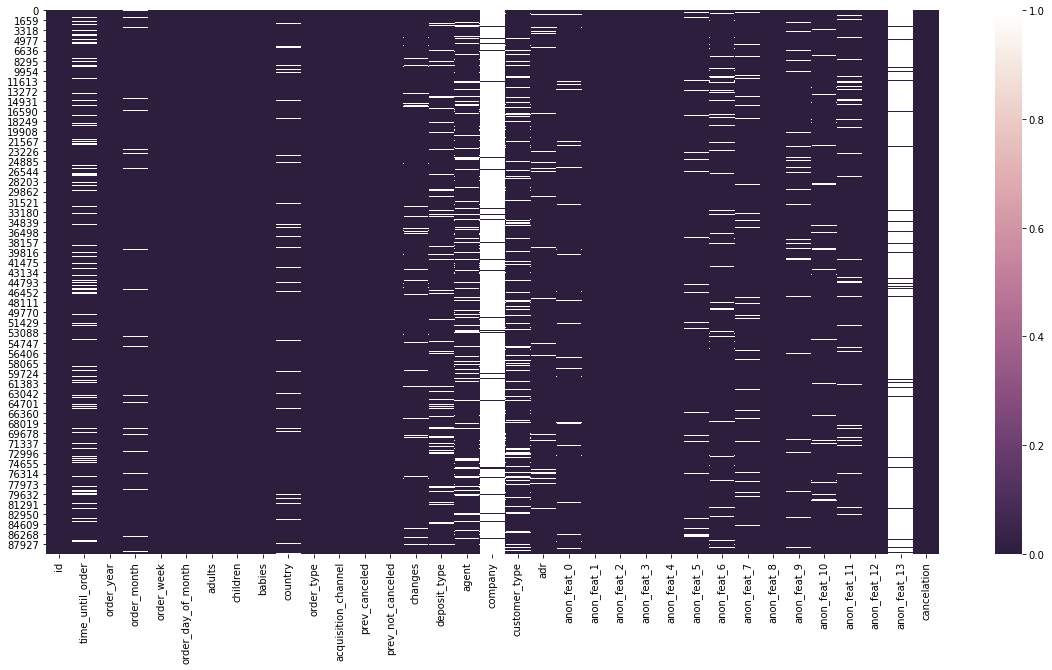

In [73]:
#plot null values per row
%matplotlib inline
plt.figure(figsize=(20, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(new_df.isnull(), cmap=cmap)

In [74]:
#drop null columns
new_df.drop(['company','anon_feat_13'], axis=1, inplace = True)

# plot null values after drop of 2 columns

<AxesSubplot:>

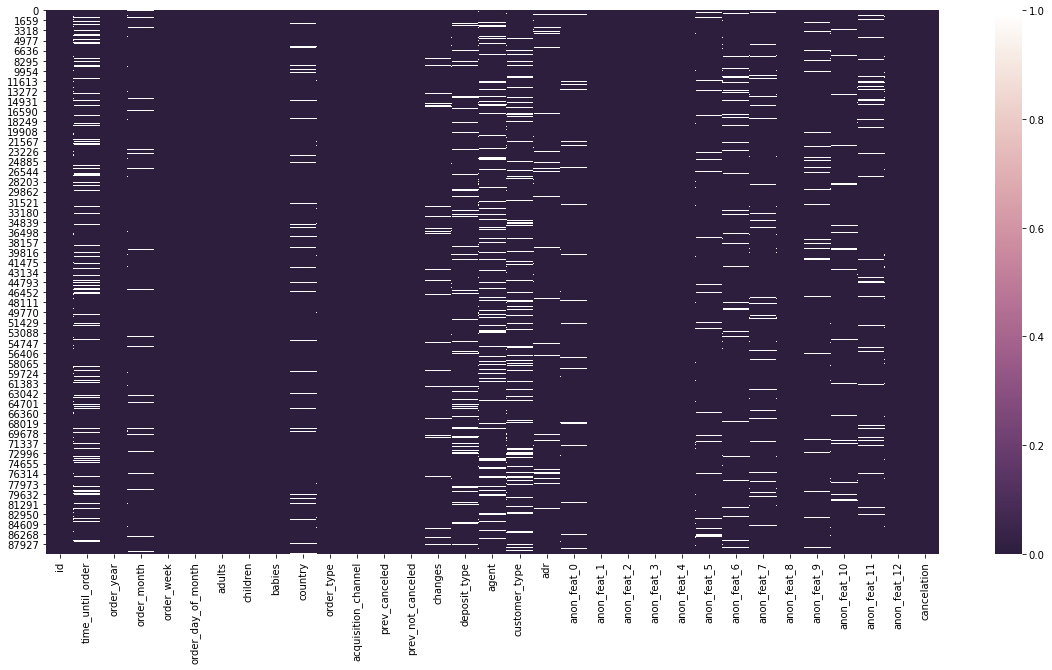

In [75]:
#plot null values per row - After drop
%matplotlib inline
plt.figure(figsize=(20, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(new_df.isnull(), cmap=cmap)

In [87]:
# we need to decide if to fillna before we do correlation heatmap or after
# fix categorial vs numerical
# fillna according to outliers in numerical - mean/median
# outliers visulaization - boxplot
# correlation heatmap
# pca


In [91]:
numerical = []
new_df.boxplot(column = [anon_feat_6],figsize=(30,10))

NameError: name 'anon_feat_6' is not defined

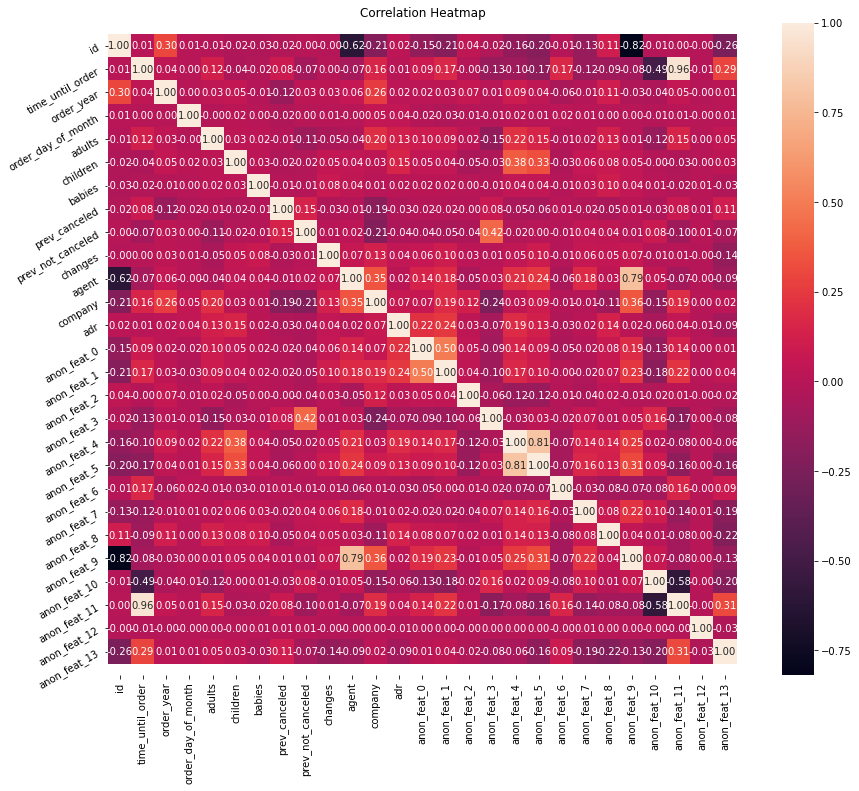

In [79]:
correlation = df.corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)                 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

In [80]:
new_df.describe()

,id,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,...,anon_feat_2,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11
count,89542.000000,76861.000000,89542.000000,89542.000000,89542.000000,89538.000000,89542.000000,89542.000000,89542.000000,86065.000000,...,89542.000000,89542.000000,89542.000000,85510.000000,85309.000000,85294.000000,89542.000000,85811.000000,86810.000000,84585.000000
mean,59716.762871,103.673879,2016.157658,15.828807,1.857497,0.103732,0.007896,0.087411,0.137701,0.223877,...,0.556901,0.032231,0.989971,1.330944,2.339401,0.062607,0.571922,0.335691,0.427146,8.845679
std,34495.242240,106.940156,0.707461,8.779753,0.565296,0.397797,0.095194,0.849799,1.496269,0.663361,...,1.069291,0.176613,1.698086,1.879927,17.516854,0.243415,0.793567,0.472234,0.128140,5.236673
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161008,0.038632
25%,29838.250000,18.000000,2016.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328012,4.452191
50%,59743.500000,69.000000,2016.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425622,8.422255
75%,89610.500000,159.000000,2017.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.511077,12.712815
max,119388.000000,737.000000,2017.000000,31.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,...,4.000000,1.000000,9.000000,11.000000,391.000000,3.000000,5.000000,1.000000,0.907525,27.172399
